In [1]:
import pandas as pd
import numpy as np


import plotly.graph_objects as go
import plotly.express as px

import pickle

import locale

import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de Desempenho
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

# Pacote de Interpretabilidade
import shap

In [2]:
# Exibir todo o conteúdo de uma célula, sem truncar o texto
pd.set_option('display.max_colwidth', None)

# Definir a formatação local para o Brasil
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Definir um alias para a função locale.format_string()
def valor(valor):
    return locale.format_string('%.2f', valor, grouping=True)

In [3]:
df_churn = pd.read_csv('data/db_churn.csv', sep=';', index_col='ClientId')
df_churn.head()

,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao
ClientId,,,,,,,,,,,,
345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14
345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05
345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20
345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21
345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26


In [4]:
# Converter colunas de data para datetime
datetime_variables = ['DataExtracao', 'DataUltimaTransacao']
for column in datetime_variables:
    df_churn[column] = pd.to_datetime(df_churn[column])

df_churn[datetime_variables].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 345568 to 355567
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DataExtracao         10000 non-null  datetime64[ns]
 1   DataUltimaTransacao  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 234.4 KB


In [5]:
# Criando a variável 'data_corte_churn'  para definir a data base como referência de corte.
data_corte_churn = pd.to_datetime('2019-10-30') - pd.to_timedelta(30, unit='d')
print(f'Data de corte: {data_corte_churn}')

# Criar a variável Churn
df_churn['Churn'] = (df_churn['DataUltimaTransacao'] <= data_corte_churn).astype(int)
taxa_churn = df_churn['Churn'].mean()

print(f'Taxa de churn: {taxa_churn:.2%}')

Data de corte: 2019-09-30 00:00:00
Taxa de churn: 20.37%


In [6]:
df = df_churn[['Estado', 'Idade', 'Limite_Credito_Mercado', 'Qte_Categorias', 'Programa_Fidelidade', 'Churn']].copy()

In [7]:
import pickle
# Carregar o modelo
with open('random_forest_best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

### Impacto
Na análise de *churn*, uma matriz de confusão ajuda a avaliar o desempenho do modelo de classificação ao prever se um cliente irá ou não desistir (*churn*) com base em diferentes categorias de previsão. 

Aqui está uma visão geral de cada tipo de resultado possível:

    1. Verdadeiro Positivo (TP)
Clientes que **irão** *churn* e foram corretamente classificados como ***churn*** pelo modelo.
Impacto: Esses são acertos do modelo, pois o modelo previu corretamente que o cliente iria *churn*.

    2. Falso Positivo (FP)
Clientes que **não irão** *churn*, mas foram incorretamente classificados como ***churn*** pelo modelo.
Impacto: O impacto pode ser um custo desnecessário associado a tentativas de retenção ou ofertas de retenção para clientes que na verdade não iriam *churn*.

    3. Verdadeiro Negativo (TN)
Clientes que **não irão** *churn* e foram corretamente classificados como **não *churn*** pelo modelo.
Impacto: Esses são acertos do modelo, pois ele corretamente identificou clientes que não irão *churn*.

    4. Falso Negativo (FN)
Clientes que realmente irão *churn*, mas foram incorretamente classificados como **não *churn*** pelo modelo.
Impacto: Este é um erro crítico do modelo. O impacto pode ser a perda de oportunidades de retenção e ações que poderiam ter evitado o *churn*.

In [8]:
df_churn['Tempo_Cliente'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tempo_Cliente, dtype: float64

In [9]:
# Quanto tempo os clientes que deram churn ficaram em média?
tempo_medio = df_churn[df_churn['Churn'] == 1]['Tempo_Cliente'].mean()
print(f'Os clientes ficam em média {valor(tempo_medio)} meses.')

Os clientes ficam em média 4,93 meses.


In [10]:
df_backtest = df_churn[['Churn', 'Tempo_Cliente', 'Sum_Pedidos_Acumulados']].copy()

# Cálculo do Ticket Médio
df_backtest['Ticket_Medio_Mensal'] = df_backtest['Sum_Pedidos_Acumulados'] / 3  # valores nos últimos 3 meses

# Cálculo do CLV
df_backtest['LTV'] = df_backtest['Ticket_Medio_Mensal'] * tempo_medio

# Cálculo do LTV médio
ltv_medio = df_backtest['LTV'].mean()

print(f'LTV médio: {ltv_medio:.2f}')

LTV médio: 685.72


In [11]:
n_cliente = 10_000

# Parâmetros financeiros
LTV = ltv_medio    # Lifetime Value
CAC = 150.00
CUPOM = 50.00   # Cupom de desconto para manter o cliente comprando

In [12]:
valor((df_backtest[df_backtest['Churn'] == 0]['LTV'] - CAC).sum())

'4.246.756,12'

## Matriz de Impacto Potencial A

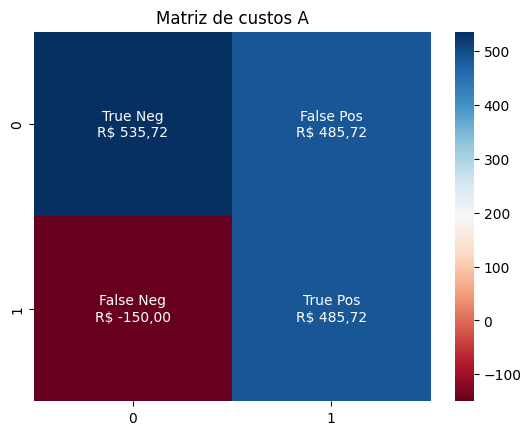

In [13]:
# Clientes que irão dar churn e foram corretamente classificados como churn pelo modelo.
impacto_TP = LTV - CAC - CUPOM

# Clientes que irão dar churn, mas foram incorretamente classificados como não churn pelo modelo.
impacto_FN = - CAC # não ganhamos o LTV mas tivemos o custo de aquisição do cliente

# Clientes que NÃO irão dar churn e foram corretamente classificados como não churn pelo modelo.
impacto_TN = LTV - CAC # não é preciso usar o cupom, pois sabemos que não darão churn

# Clientes que NÃO irão dar churn, mas foram incorretamente classificados como churn pelo modelo.
impacto_FP = LTV - CAC - CUPOM


# Criar a matriz de custos financeiro
matriz_custosA = np.array([[impacto_TN, impacto_FP],
                          [impacto_FN, impacto_TP]])



# Matriz de impacto

group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = [f"R$ {valor(value)}" for value in
                matriz_custosA.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_custosA, annot=labels, fmt='', cmap='RdBu')
plt.title('Matriz de custos A')
plt.show()

In [14]:
# Pré-processamento
data = pd.get_dummies(df, drop_first=False, dtype=int)  # treinado com drop_first=True em LG (Verificar)

# Divisão entre features e target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Matriz de custo A

In [15]:
# Definir os cortes de probabilidade
thresholds = np.arange(0, 1.01, 0.01)

# Fazer previsões de probabilidade com o modelo carregado
y_prob = loaded_model.predict_proba(X_test)[:, 1]


# Criar as matrizes de confusão e as matrizes de impacto para cada corte
impact_data = []

for threshold in thresholds:
    # Aplicar o corte de probabilidade para gerar previsões binárias
    y_pred = (y_prob >= threshold).astype(int)
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
    # normalize='all') retorna a % de cada valor sobre o total, permitindo escalar para o total de clientes da base

    # Calcular o impacto financeiro para cada valor da matriz de confusão
    impacto_potencial = conf_matrix * matriz_custosA * n_cliente
                     
    
    impact_data.append({
        'threshold': threshold,
        'TN': impacto_potencial[0, 0],
        'FP': impacto_potencial[0, 1],
        'FN': impacto_potencial[1, 0],
        'TP': impacto_potencial[1, 1],
        'impacto_potencial': impacto_potencial.sum(),
    })

# Criar DataFrame
df_impact = pd.DataFrame(impact_data).set_index('threshold')

# Mostrar o DataFrame
df_impact

,TN,FP,FN,TP,impacto_potencial
threshold,,,,,
0.00,0.000000e+00,3.911678e+06,-0.0,945538.051850,4.857216e+06
0.01,0.000000e+00,3.911678e+06,-0.0,945538.051850,4.857216e+06
0.02,1.857168e+05,3.743294e+06,-1000.0,942299.907836,4.870311e+06
0.03,5.267929e+05,3.434052e+06,-3500.0,934204.547803,4.891549e+06
0.04,9.125125e+05,3.084332e+06,-5000.0,929347.331784,4.921192e+06
...,...,...,...,...,...
0.96,4.314345e+06,0.000000e+00,-292000.0,0.000000,4.022345e+06
0.97,4.314345e+06,0.000000e+00,-292000.0,0.000000,4.022345e+06
0.98,4.314345e+06,0.000000e+00,-292000.0,0.000000,4.022345e+06


In [16]:
df_impact.reset_index(inplace=True)

In [17]:
import plotly.graph_objects as go



# Encontrar os valores mínimo e máximo do df
min = abs(df_impact.min().min())
min = -min - 10 ** int(np.log10(min))

max = abs(df_impact.max().max())
max = max + 10 ** int(np.log10(max))


# Encontrar o índice do maior impacto_potencial
threshold_index_inicial = df_impact['impacto_potencial'].idxmax()

# Função para criar a figura inicial do gráfico de cascata
def create_waterfall_figure(df, threshold_index):
    threshold = df['threshold'].iloc[threshold_index]
    values = [
        df['TN'].iloc[threshold_index],
        df['FP'].iloc[threshold_index],
        df['FN'].iloc[threshold_index],
        df['TP'].iloc[threshold_index],
    ]
    labels = ['TN', 'FP', 'FN', 'TP']
    total = df['impacto_potencial'].iloc[threshold_index]

    fig = go.Figure()

    fig.add_trace(go.Waterfall(
        name="Impacto Potencial",
        orientation="v",
        measure=["relative"] * len(values) + ["total"],
        x=labels + ['Impacto Potencial'],
        y=values + [total],
        base=0,
        connector={"line": {"color": "rgba(63, 63, 63, 0.8)"}},
        decreasing={"marker": {"color": "#e65a6d"}}, #red
        increasing={"marker": {"color": "#a3dce8"}}, #blue
        totals={"marker": {"color": "#003755" if total >= 0 else "red"}},
        text=[f"R$ {valor(v)}" for v in values] + [f"R$ {valor(total)}"]
    ))

    fig.update_layout(
        title=f"Impacto Potencial para {n_cliente} clientes com Threshold {threshold:.2f}",
        xaxis_title="Categoria",
        yaxis_title="Impacto Financeiro (R$)",
        title_font_size=20,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        yaxis=dict(range=[min, max])
    )

    return fig

# Criação inicial da figura
fig = create_waterfall_figure(df_impact, threshold_index_inicial)

# Criar o controle deslizante
steps = []
for i in range(len(thresholds)):

    step = {
        'method': 'update',
        'args': [
            {
                'y': [
                    [df_impact['TN'].iloc[i], 
                     df_impact['FP'].iloc[i], 
                     df_impact['FN'].iloc[i], 
                     df_impact['TP'].iloc[i], 
                     df_impact['impacto_potencial'].iloc[i]],  # Valores do gráfico de cascata e impacto total
                ],
                'totals':{"marker": {"color": "#003755" if df_impact['impacto_potencial'].iloc[i] >= 0 else "red"}},
                'text': [
                    [f"R$ {valor(v)}" for v in [df_impact['TN'].iloc[i],
                                                df_impact['FP'].iloc[i], 
                                                df_impact['FN'].iloc[i], 
                                                df_impact['TP'].iloc[i], 
                                                df_impact['impacto_potencial'].iloc[i]]]  # Textos
                ]
            },
            {'title': f"Impacto Potencial para {n_cliente} clientes com Threshold {df_impact['threshold'].iloc[i]:.2f}"}
        ],
        'label': f"{thresholds[i]:.2f}"    
    }
    steps.append(step)

sliders = [{
    'active': threshold_index_inicial,
    'pad': {"t": 50},
    'steps': steps
}]

fig.update_layout(
    sliders=sliders
)

# Mostrar o gráfico
fig.show()


In [18]:
import plotly.express as px


# Encontrar o índice e o valor do maior impacto_potencial
max_index = df_impact['impacto_potencial'].idxmax()
max_value = df_impact['impacto_potencial'].max()

# Criar gráfico de barras para o impacto total
fig_bar = px.bar(df_impact, x='threshold', y='impacto_potencial',
                 title=f'Impacto Potencial para {n_cliente} vs Threshold',
                 labels={'threshold': 'Threshold', 'impacto_potencial': 'Impacto Potencial (R$)'})

# Alterar a cor da barra máxima
colors = ['#e65a6d'] * len(df_impact) #red
colors[max_index] = '#003755'  # Destacar a barra máxima com cor azul

fig_bar.update_traces(marker_color=colors)

# Adicionar anotação para o valor mais alto
fig_bar.add_annotation(
    x=df_impact['threshold'][max_index],
    y=max_value,
    text=f'Valor máximo: R$ {valor(max_value)}',
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(color="#003755", size=12)
)

fig_bar.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16
)

fig_bar.show()


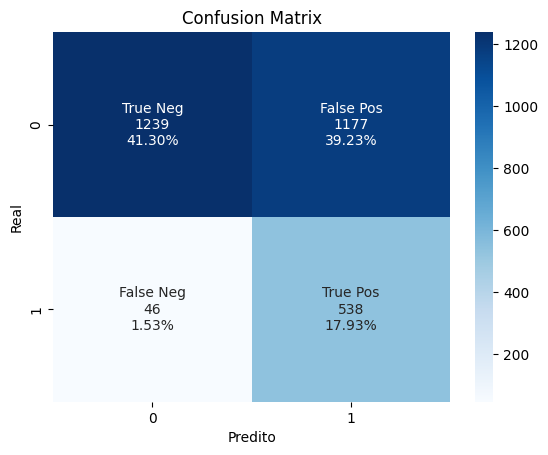

In [19]:
y_pred = (y_prob >= 0.09).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# valor potencial com o melhor ajuste no corte de probabilidades
value_model = max_value 

# valor estimado caso sem uso do modelo
value_no_model = df_impact[df_impact['threshold'] == 1]['impacto_potencial'].values[0]

In [21]:
ganho_em_valor_financeiro = value_model - value_no_model
ganho = (value_model / value_no_model - 1)
print(f'O ganho em relação ao método atual é de R$ {valor(ganho_em_valor_financeiro)} ({ganho:.2%})')

O ganho em relação ao método atual é de R$ 943.894,07 (23.47%)


## Matriz de Impacto Potencial B

##### Matriz de custos

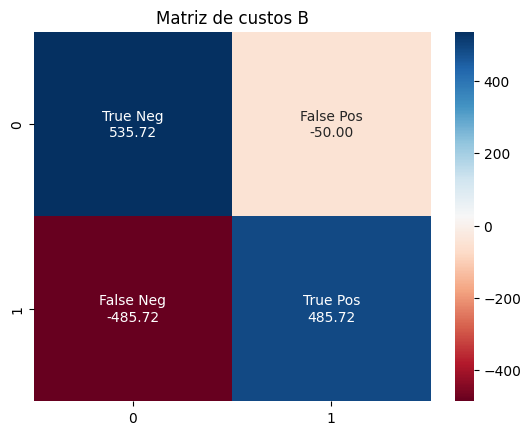

In [22]:
# Clientes que irão dar churn e foram corretamente classificados como churn pelo modelo.
impacto_TP = LTV - CAC - CUPOM

# Clientes que irão dar churn, mas foram incorretamente classificados como não churn pelo modelo.
impacto_FN = - impacto_TP # Perdemos a oportunidade de ganho caso o modelo acertasse.

# Clientes que NÃO irão dar churn e foram corretamente classificados como não churn pelo modelo.
impacto_TN = LTV - CAC

# Clientes que NÃO irão dar churn, mas foram incorretamente classificados como churn pelo modelo.
impacto_FP = impacto_TP - impacto_TN # Ganhamos o mesmo valor de VP, mas perdemos a oportunidade de ganho de VN caso o modelo acertasse.


# Criar a matriz de custos financeiro
matriz_custosB = np.array([[impacto_TN, impacto_FP],
                          [impacto_FN, impacto_TP]])


# Matriz de impacto

group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.2f}".format(value) for value in
                matriz_custosB.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_custosB, annot=labels, fmt='', cmap='RdBu')
plt.title('Matriz de custos B')
plt.show()

In [23]:
# Pré-processamento
data = pd.get_dummies(df, drop_first=False, dtype=int)  # treinado com drop_first=True em LG (Verificar)

# Divisão entre features e target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Definir os cortes de probabilidade
thresholds = np.arange(0, 1.01, 0.01)

# Fazer previsões de probabilidade com o modelo carregado
y_prob = loaded_model.predict_proba(X_test)[:, 1]


# Criar as matrizes de confusão e as matrizes de impacto para cada corte
impact_data = []

for threshold in thresholds:
    # Aplicar o corte de probabilidade para gerar previsões binárias
    y_pred = (y_prob >= threshold).astype(int)
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
    # normalize='all') retorna a % de cada valor sobre o total, permitindo escalar para o total de clientes da base

    # Calcular o impacto financeiro para cada valor da matriz de confusão
    impacto_potencial = conf_matrix * matriz_custosB * n_cliente
                     
    
    impact_data.append({
        'threshold': threshold,
        'TN': impacto_potencial[0, 0],
        'FP': impacto_potencial[0, 1],
        'FN': impacto_potencial[1, 0],
        'TP': impacto_potencial[1, 1],
        'impacto_potencial': impacto_potencial.sum(),
    })

# Criar DataFrame
df_impact = pd.DataFrame(impact_data).set_index('threshold')

# Mostrar o DataFrame
df_impact

,TN,FP,FN,TP,impacto_potencial
threshold,,,,,
0.00,0.000000e+00,-402666.666667,-0.000000,945538.051850,5.428714e+05
0.01,0.000000e+00,-402666.666667,-0.000000,945538.051850,5.428714e+05
0.02,1.857168e+05,-385333.333333,-3238.144013,942299.907836,7.394453e+05
0.03,5.267929e+05,-353500.000000,-11333.504046,934204.547803,1.096164e+06
0.04,9.125125e+05,-317500.000000,-16190.720066,929347.331784,1.508169e+06
...,...,...,...,...,...
0.96,4.314345e+06,-0.000000,-945538.051850,0.000000,3.368807e+06
0.97,4.314345e+06,-0.000000,-945538.051850,0.000000,3.368807e+06
0.98,4.314345e+06,-0.000000,-945538.051850,0.000000,3.368807e+06


In [25]:
df_impact.reset_index(inplace=True)

In [26]:
# Encontrar os valores mínimo e máximo do df
min = abs(df_impact.min().min())
min = -min - 10 ** int(np.log10(min))

max = abs(df_impact.max().max())
max = max + 10 ** int(np.log10(max))


# Encontrar o índice do maior impacto_potencial
threshold_index_inicial = df_impact['impacto_potencial'].idxmax()

# Função para criar a figura inicial do gráfico de cascata
def create_waterfall_figure(df, threshold_index):
    threshold = df['threshold'].iloc[threshold_index]
    values = [
        df['TN'].iloc[threshold_index],
        df['FP'].iloc[threshold_index],
        df['FN'].iloc[threshold_index],
        df['TP'].iloc[threshold_index],
    ]
    labels = ['TN', 'FP', 'FN', 'TP']
    total = df['impacto_potencial'].iloc[threshold_index]

    fig = go.Figure()

    fig.add_trace(go.Waterfall(
        name="Impacto Potencial",
        orientation="v",
        measure=["relative"] * len(values) + ["total"],
        x=labels + ['Impacto Potencial'],
        y=values + [total],
        base=0,
        connector={"line": {"color": "rgba(63, 63, 63, 0.8)"}},
        decreasing={"marker": {"color": "#e65a6d"}}, #red
        increasing={"marker": {"color": "#a3dce8"}}, #blue
        totals={"marker": {"color": "#003755" if total >= 0 else "red"}},
        text=[f"R$ {valor(v)}" for v in values] + [f"R$ {valor(total)}"]
    ))

    fig.update_layout(
        title=f"Impacto Potencial para {n_cliente} clientes com Threshold {threshold:.2f}",
        xaxis_title="Categoria",
        yaxis_title="Impacto Financeiro (R$)",
        title_font_size=20,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        yaxis=dict(range=[min, max])
    )

    return fig

# Criação inicial da figura
fig = create_waterfall_figure(df_impact, threshold_index_inicial)

# Criar o controle deslizante
steps = []
for i in range(len(thresholds)):

    step = {
        'method': 'update',
        'args': [
            {
                'y': [
                    [df_impact['TN'].iloc[i], 
                     df_impact['FP'].iloc[i], 
                     df_impact['FN'].iloc[i], 
                     df_impact['TP'].iloc[i], 
                     df_impact['impacto_potencial'].iloc[i]],  # Valores do gráfico de cascata e impacto total
                ],
                'totals':{"marker": {"color": "#003755" if df_impact['impacto_potencial'].iloc[i] >= 0 else "red"}},
                'text': [
                    [f"R$ {valor(v)}" for v in [df_impact['TN'].iloc[i],
                                                df_impact['FP'].iloc[i], 
                                                df_impact['FN'].iloc[i], 
                                                df_impact['TP'].iloc[i], 
                                                df_impact['impacto_potencial'].iloc[i]]]  # Textos
                ]
            },
            {'title': f"Impacto Potencial para {n_cliente} clientes com Threshold {df_impact['threshold'].iloc[i]:.2f}"}
        ],
        'label': f"{thresholds[i]:.2f}"    
    }
    steps.append(step)

sliders = [{
    'active': threshold_index_inicial,
    'pad': {"t": 50},
    'steps': steps
}]

fig.update_layout(
    sliders=sliders
)

# Mostrar o gráfico
fig.show()


In [27]:
# Encontrar o índice e o valor do maior impacto_potencial
max_index = df_impact['impacto_potencial'].idxmax()
max_value = df_impact['impacto_potencial'].max()

# Criar gráfico de barras para o impacto total
fig_bar = px.bar(df_impact, x='threshold', y='impacto_potencial',
                 title=f'Impacto Potencial para {n_cliente} vs Threshold',
                 labels={'threshold': 'Threshold', 'impacto_potencial': 'Impacto Potencial (R$)'})

# Alterar a cor da barra máxima
colors = ['#e65a6d'] * len(df_impact) #red
colors[max_index] = '#003755'  # Destacar a barra máxima com cor azul

fig_bar.update_traces(marker_color=colors)

# Adicionar anotação para o valor mais alto
fig_bar.add_annotation(
    x=df_impact['threshold'][max_index],
    y=max_value,
    text=f'Valor máximo: R$ {valor(max_value)}',
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(color="#003755", size=12)
)

fig_bar.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16
)

fig_bar.show()


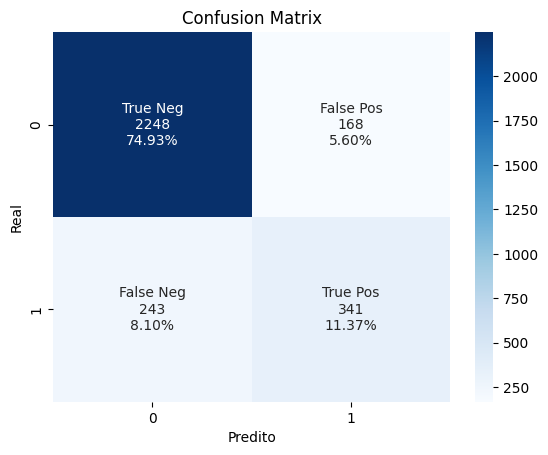

In [28]:
y_pred = (y_prob >= 0.34).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# valor potencial com o melhor ajuste no corte de probabilidades
value_model = max_value 

# valor estimado caso sem uso do modelo
value_no_model = df_impact[df_impact['threshold'] == 1]['impacto_potencial'].values[0]

In [30]:
ganho_em_valor_financeiro = value_model - value_no_model
ganho = (value_model / value_no_model - 1)
print(f'O ganho em relação ao método atual é de R$ {valor(ganho_em_valor_financeiro)} ({ganho:.2%})')

O ganho em relação ao método atual é de R$ 776.203,01 (23.04%)


### Extração do Aprendizado da Random Forest

In [31]:
df.head()


,Estado,Idade,Limite_Credito_Mercado,Qte_Categorias,Programa_Fidelidade,Churn
ClientId,,,,,,
345568,São Paulo,42,0.0000,1,1,1
345569,Rio de Janeiro,41,838.0786,1,1,0
345570,São Paulo,42,1596.6080,3,0,1
345571,São Paulo,39,0.0000,2,0,0
345572,Rio de Janeiro,43,1255.1082,1,1,0


In [32]:
# explain all the predictions in the test set
#explainer = shap.KernelExplainer(loaded_model.predict_proba, X_train[:100])

In [33]:
X_test = X_test[:1000].values

In [34]:
#shap_values = explainer.shap_values(X_test)

In [35]:
#shap.force_plot(explainer.expected_value[1], shap_values[..., 1], X_test[:10])

##

In [36]:
# ATENÇÃO: ajustar o shap_values de acordo com a saída do modelo
#shap.summary_plot(shap_values=shap_values[..., 1], plot_type='bar', feature_names=X.columns)

In [37]:
# Built-in feature importance (Gini Importance)
feature_names = loaded_model.feature_names_in_
importances = loaded_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)


                  Feature  Gini Importance
0                   Idade         0.417985
2          Qte_Categorias         0.290167
1  Limite_Credito_Mercado         0.139526
3     Programa_Fidelidade         0.085346
4     Estado_Minas Gerais         0.045938
6        Estado_São Paulo         0.011806
5   Estado_Rio de Janeiro         0.009232


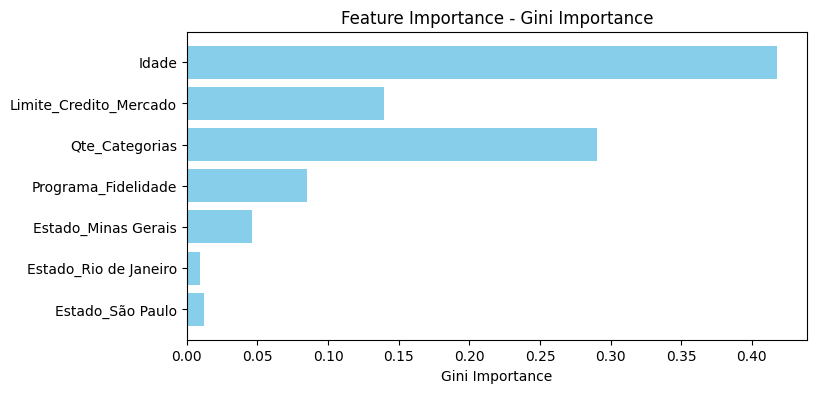

In [38]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [39]:
# Utilizar uma amostra de até 1.000 observações para extração do conhecimento
rf_explainer = shap.TreeExplainer(model=loaded_model, 
                                  data=X_train[:1000])

rf_shap_values = rf_explainer.shap_values(X=X_test)

100%|===================| 1994/2000 [06:32<00:01]        

In [40]:
feat_lst = loaded_model.feature_names_in_
feat_lst

array(['Idade', 'Limite_Credito_Mercado', 'Qte_Categorias',
       'Programa_Fidelidade', 'Estado_Minas Gerais',
       'Estado_Rio de Janeiro', 'Estado_São Paulo'], dtype=object)

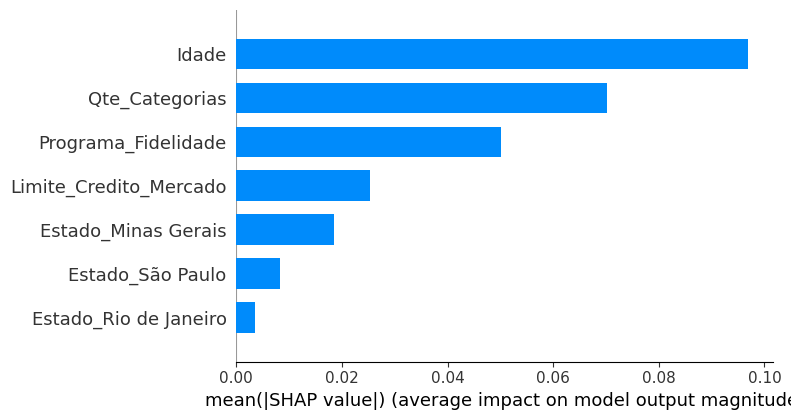

In [41]:
# ATENÇÃO: ajustar o shap_values de acordo com a saída do modelo
shap.summary_plot(shap_values=rf_shap_values[..., 1],
                  plot_type='bar',
                  feature_names=feat_lst)

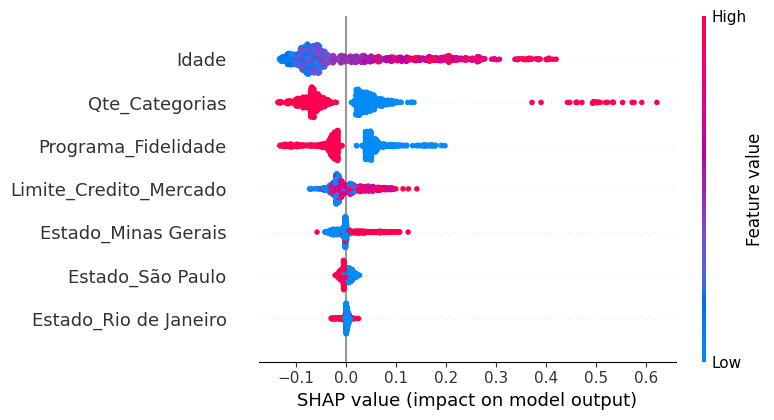

In [42]:
# ATENÇÃO: ajustar o shap_values de acordo com a saída do modelo
shap.summary_plot(shap_values=rf_shap_values[..., 1], 
                  features=X_test,
                  feature_names=feat_lst,
                  plot_type='dot')

In [43]:
feat_lst

array(['Idade', 'Limite_Credito_Mercado', 'Qte_Categorias',
       'Programa_Fidelidade', 'Estado_Minas Gerais',
       'Estado_Rio de Janeiro', 'Estado_São Paulo'], dtype=object)

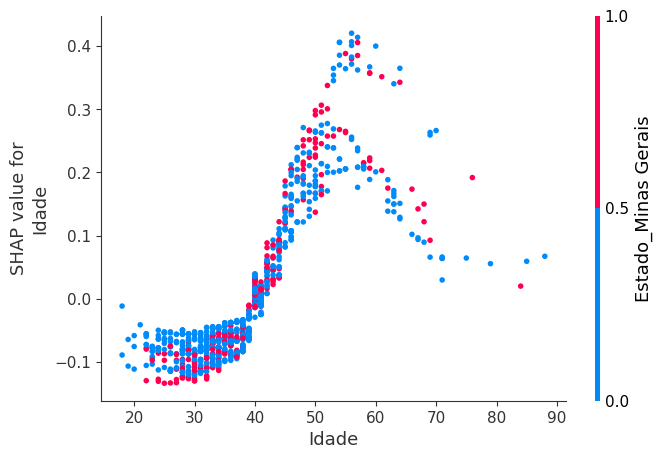

In [44]:
# Feature: Sex_male
shap.dependence_plot(ind='Idade', 
                     shap_values=rf_shap_values[..., 1], 
                     features=X_test,
                     feature_names=feat_lst, 
                     interaction_index='Estado_Minas Gerais')

### Shapley Values

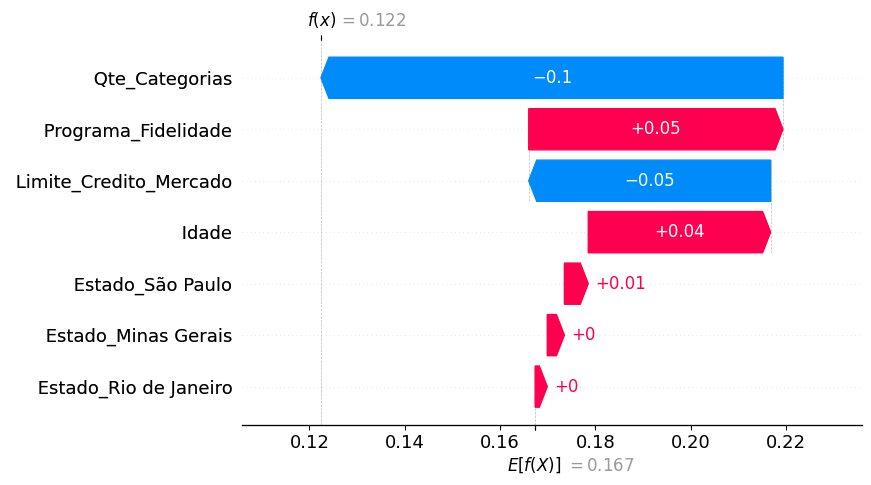

In [45]:
id_obs = 2

shap.plots._waterfall.waterfall_legacy(expected_value=rf_explainer.expected_value[1],
                                       shap_values=rf_shap_values[..., 1][id_obs],
                                       feature_names=feat_lst, 
                                       features=X_test[id_obs])

In [46]:
shap.initjs()

shap.force_plot(base_value=rf_explainer.expected_value[1], 
                shap_values=rf_shap_values[..., 1][id_obs],
                feature_names=feat_lst,
                features=X_test[id_obs])